In [1]:
%matplotlib inline

from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists
import psycopg2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We need to pull our timeseries data out of our database. Since we have multiple stations, I'll join them using SQL on the time index, so that everything lines up and I should be OK. I have no idea if this will work...

Ideas from Insight alums:
- seasonal riema (moving average, autoregressive) and general time series techniques
- add 311 call data? (second order effect)
- compare to other options (uber/lyft/etc not localized, taxi possibly, bus not available)
- random forest regression to get ridership? Features are riders at `t-1`, `t-2`, etc.
- `pymc3` to do GLM analysis

In [2]:
user = 'mikemoran'
host = 'localhost'
dbname = 'stations'

engine = create_engine(f'postgres://{user}@{host}/{dbname}')
conn = None
conn = psycopg2.connect(database=dbname, user=user)

In [3]:
tables = ['second72', 'second86', 'second96',
          'g68', 'g77', 'g86', 'g96',
          'g103', 'g110', 'g116', 'g125']
renames = ['s72', 's86', 's96',
           'g68', 'g77', 'g86', 'g96',
           'g103', 'g110', 'g116', 'g125']

select = '{}.d_entries {}_in, {}.d_exits {}_out'
joins = 'left join {} {} on l.date = {}.date'

select_parts = ['select l.date, l.d_entries l_in, l.d_exits l_out']
join_parts = ['from lexington l']
for old, new in zip(tables, renames):
    new_select = select.format(new, new, new, new)
    select_parts.append(new_select)
    new_join = joins.format(old, new, new)
    join_parts.append(new_join)
select_str = ',\n'.join(select_parts)
query = '\n'.join([select_str, *join_parts, ';'])
print(query)

select l.date, l.d_entries l_in, l.d_exits l_out,
s72.d_entries s72_in, s72.d_exits s72_out,
s86.d_entries s86_in, s86.d_exits s86_out,
s96.d_entries s96_in, s96.d_exits s96_out,
g68.d_entries g68_in, g68.d_exits g68_out,
g77.d_entries g77_in, g77.d_exits g77_out,
g86.d_entries g86_in, g86.d_exits g86_out,
g96.d_entries g96_in, g96.d_exits g96_out,
g103.d_entries g103_in, g103.d_exits g103_out,
g110.d_entries g110_in, g110.d_exits g110_out,
g116.d_entries g116_in, g116.d_exits g116_out,
g125.d_entries g125_in, g125.d_exits g125_out
from lexington l
left join second72 s72 on l.date = s72.date
left join second86 s86 on l.date = s86.date
left join second96 s96 on l.date = s96.date
left join g68 g68 on l.date = g68.date
left join g77 g77 on l.date = g77.date
left join g86 g86 on l.date = g86.date
left join g96 g96 on l.date = g96.date
left join g103 g103 on l.date = g103.date
left join g110 g110 on l.date = g110.date
left join g116 g116 on l.date = g116.date
left join g125 g125 on l.date =

In [4]:
df = pd.read_sql(query, conn)
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df_modern = df[df.date >= pd.datetime(2016, 1, 1)]
df, df_modern = df_modern, df
df.set_index('date', drop=True, inplace=True)
df.sort_index(inplace=True)
df.head()

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,l_in,l_out,s72_in,s72_out,s86_in,s86_out,s96_in,s96_out,g68_in,g68_out,...,g96_in,g96_out,g103_in,g103_out,g110_in,g110_out,g116_in,g116_out,g125_in,g125_out
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,3302.0,3146.0,NaN,NaN,NaN,NaN,NaN,NaN,9521.0,7198.0,...,10097.0,2628.0,7678.0,7633.0,5749.0,5347.0,9343.0,5262.0,9084.0,13426.0
2016-01-02,4254.0,3987.0,NaN,NaN,NaN,NaN,NaN,NaN,4706.0,5430.0,...,6141.0,2913.0,6481.0,6787.0,5359.0,4253.0,7507.0,2970.0,10346.0,17843.0
2016-01-03,4173.0,3275.0,NaN,NaN,NaN,NaN,NaN,NaN,3401.0,4513.0,...,3682.0,2294.0,5143.0,6098.0,4219.0,3907.0,6427.0,2747.0,9516.0,17188.0
2016-01-04,8824.0,7496.0,NaN,NaN,NaN,NaN,NaN,NaN,28379.0,19186.0,...,24008.0,4968.0,14419.0,13755.0,12151.0,9270.0,15698.0,8035.0,19381.0,23519.0
2016-01-05,9622.0,7700.0,NaN,NaN,NaN,NaN,NaN,NaN,31805.0,19920.0,...,25705.0,5205.0,15140.0,14409.0,12226.0,9137.0,15590.0,8412.0,19085.0,23511.0


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


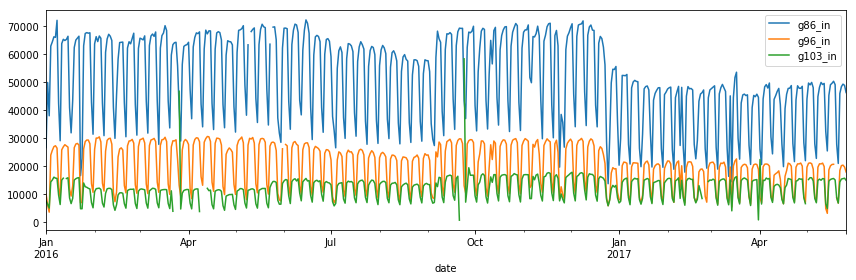

In [5]:
df.plot(kind='line', y=['g86_in', 'g96_in', 'g103_in'],
        figsize=(12, 4))

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


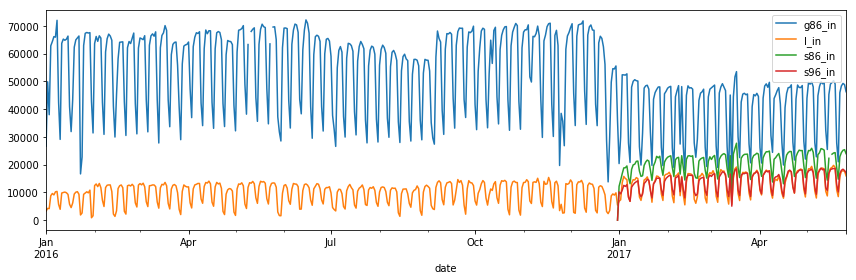

In [6]:
df.plot(kind='line', y=['g86_in', 'l_in', 's86_in', 's96_in'],
        figsize=(12, 4))

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


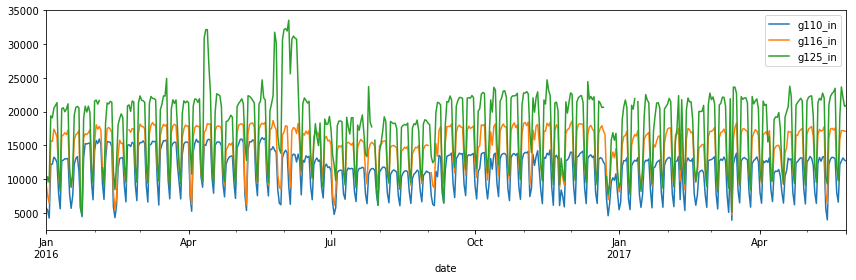

In [7]:
# df.g116_in[df.g116_in > 40000] = np.NaN
df.plot(kind='line', y=['g110_in', 'g116_in', 'g125_in'],
        figsize=(12, 4))

In [8]:
ins = list(filter(lambda x: 'in' in x, df.columns))
outs = list(filter(lambda x: 'out' in x, df.columns))

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


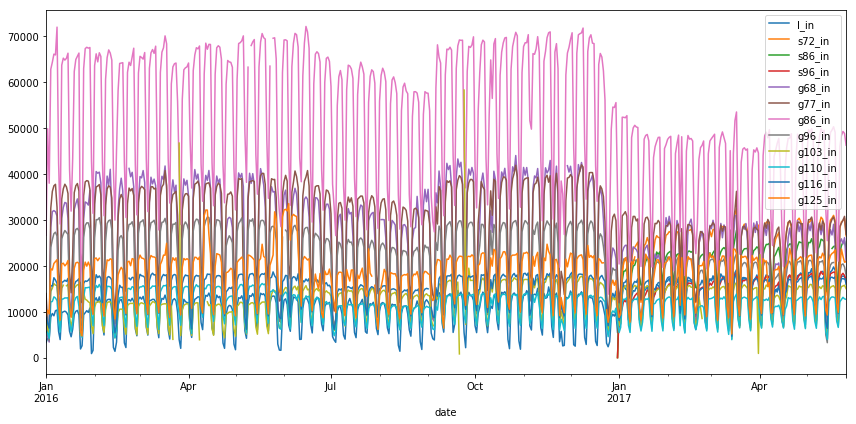

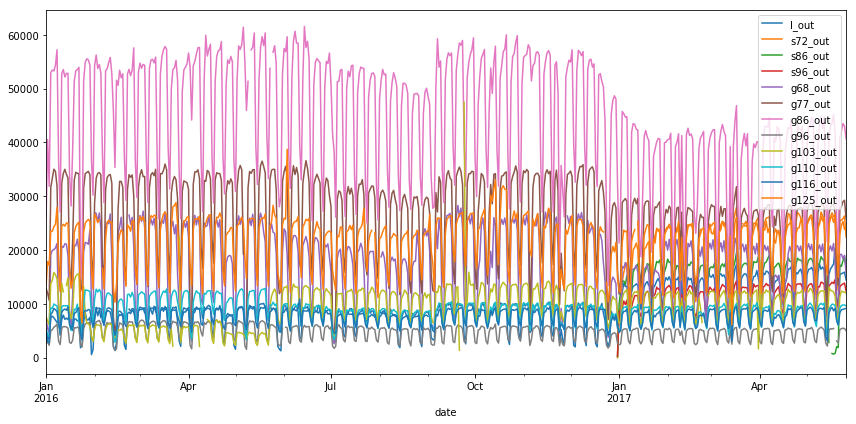

In [9]:
df.plot(kind='line', y=ins, figsize=(12, 6))
df.plot(kind='line', y=outs, figsize=(12, 6))

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


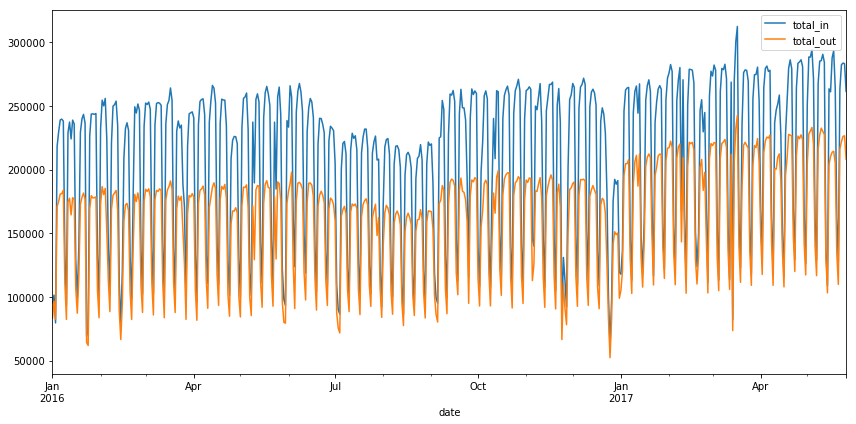

In [10]:
df['total_in'] = df[ins].sum(axis=1)
df['total_out'] = df[outs].sum(axis=1)

df.plot(kind='line', y=['total_in', 'total_out'], figsize=(12, 6))

Time Series Effects
===========

OK, we have a relatively slow increase in passengers, so let's pull out that component as an initial predictor of upper east side subway demand. From there, we can look at individual components (stations) that lead to that total, find correlations, and make station-by-station predictions depending on events (closures, openings) that happen within this restricted system.

In [11]:
window = 21

total_mean = df['total_in'].rolling(window=window, center=True).mean()
total_std = df['total_in'].rolling(window=window, center=True).std()
index = df.index
# index
window_data = [('mean_riders', total_mean), ('std_riders', total_std)]
mean_frame = pd.DataFrame.from_items(window_data)
mean_frame.set_index(index, inplace=True)
mean_frame.head()

,mean_riders,std_riders
date,,
2016-01-01,NaN,NaN
2016-01-02,NaN,NaN
2016-01-03,NaN,NaN
2016-01-04,NaN,NaN
2016-01-05,NaN,NaN


In [12]:
test_index = pd.DatetimeIndex(freq='D',
                start=pd.datetime(2015, 1, 1), end=pd.datetime(2017, 12, 31))
test_index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=1096, freq='D')

In [13]:
# df.index[df.index != test_index[:512]]
# df.sort_index(inplace=True)
# df.index[df.index != test_index[:512]]

# # df.reset_index(inplace=True)
# # df.index = test_index[:512]
# # df.tail()

In [14]:
# df.index = test_index[:512]
# df.index

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


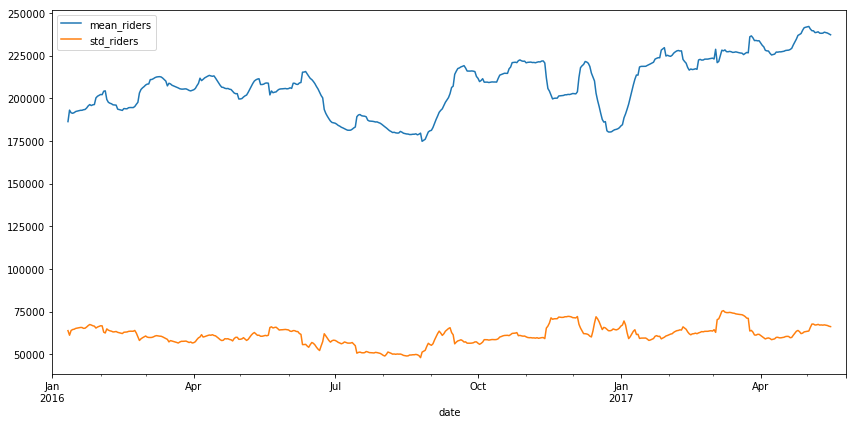

In [15]:
mean_frame.plot(kind='line', y=['mean_riders', 'std_riders'], figsize=(12, 6))

In [16]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['total_in'], autolag='AIC')
dftest
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
dfoutput

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Test Statistic                  -3.353449
p-value                          0.012652
#Lags Used                      15.000000
Number of Observations Used    496.000000
Critical Value (1%)             -3.443603
Critical Value (5%)             -2.867385
Critical Value (10%)            -2.569883
dtype: float64

Our ridership data is adequately stationary, which is great for short-term projections. I expect that ridership on the 5+ year scale would be trended upward, but in our case we don't need to worry about it. That also means that the ridership on the upper east side is relatively constant, so the new stations are cannibalizing riders from nearby stations.

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


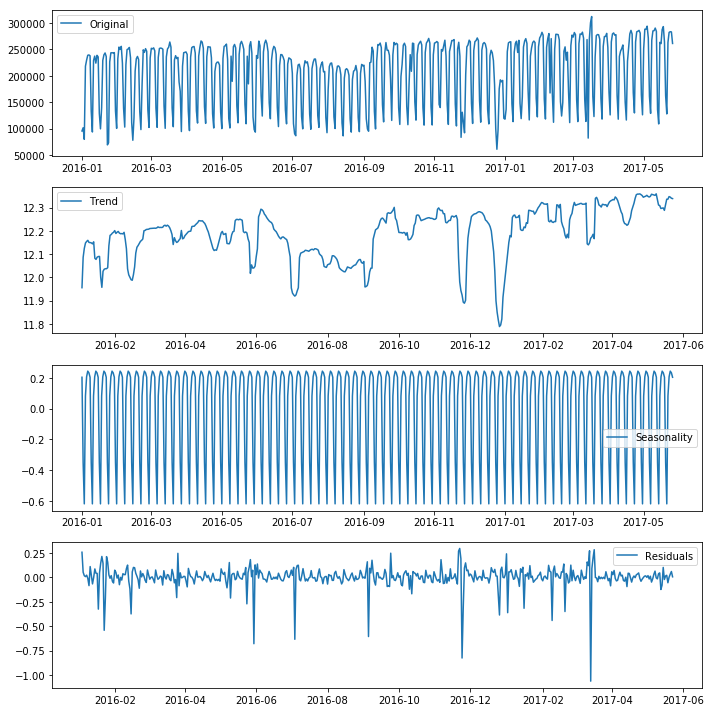

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_deco = seasonal_decompose(np.log(df['total_in']), freq=7)
trend = weekly_deco.trend
seasonal = weekly_deco.seasonal
residual = weekly_deco.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df['total_in'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

The above seasonality picks out the weekly differences in the ridership, which makes sense based on the data. We can't really get anything out of this, except maybe removing the weekly differences from the data. Let's see if that helps...

In [30]:
yearly_deco = seasonal_decompose(trend.dropna(), freq=365)
trend_y = yearly_deco.trend
seasonal_y = yearly_deco.seasonal
residual_y = yearly_deco.resid

# trend.dropna().head()

# plt.figure(figsize=(10, 10))
# plt.subplot(411)
# plt.plot(df['total_in'], label='Original')
# plt.legend(loc='best')
# plt.subplot(412)
# plt.plot(trend_y, label='Trend')
# plt.legend(loc='best')
# plt.subplot(413)
# plt.plot(seasonal_y,label='Seasonality')
# plt.legend(loc='best')
# plt.subplot(414)
# plt.plot(residual_y, label='Residuals')
# plt.legend(loc='best')
# plt.tight_layout()

The above gets a trend from the weekly trended data, since it is obscuring the actual trend. So, my model needs to pick out the weekly trend to do fine-grained forecasting, and the overall trend for long-term forecasting. Combining those two, with a rough idea on the yearly changes, should give me a full model.

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


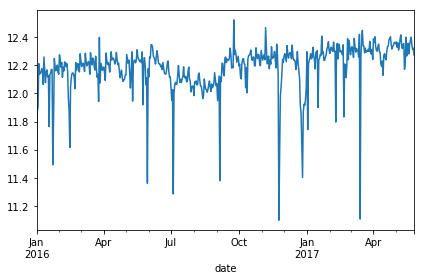

In [31]:
df_no_weekly = np.log(df['total_in']) - seasonal
df_no_weekly.plot(kind='line')

In [32]:
dftest = adfuller(df_no_weekly, autolag='AIC')
dftest
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
dfoutput

Test Statistic                -7.022686e+00
p-value                        6.482112e-10
#Lags Used                     3.000000e+00
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64

Again, no trend is apparent. It's probably because I'm using only 1.5 years of data. Let's use our longer-term data.

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


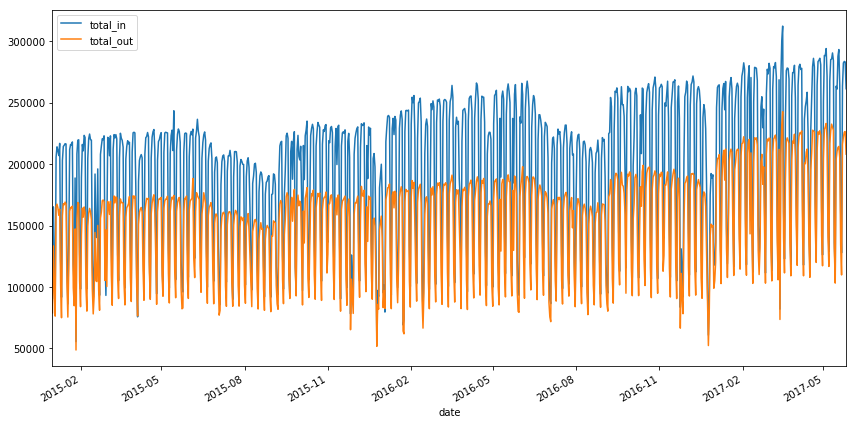

In [33]:
df_modern.set_index('date', inplace=True, drop=True)
df_modern['total_in'] = df_modern[ins].sum(axis=1)
df_modern['total_out'] = df_modern[outs].sum(axis=1)

df_modern.plot(kind='line', y=['total_in', 'total_out'], figsize=(12, 6))

It looks about the same as our old series, which is great for our total ridership numbers. What we don't know from this is what potential demand for new customers we'll get from the remainder of the upper east side. The 2017 data does look like it is trending upward, so maybe something is going on there... Let's do the "text messaging changeover" test, but still just looking at the

In [34]:
df.columns

Index(['l_in', 'l_out', 's72_in', 's72_out', 's86_in', 's86_out', 's96_in',
       's96_out', 'g68_in', 'g68_out', 'g77_in', 'g77_out', 'g86_in',
       'g86_out', 'g96_in', 'g96_out', 'g103_in', 'g103_out', 'g110_in',
       'g110_out', 'g116_in', 'g116_out', 'g125_in', 'g125_out', 'total_in',
       'total_out'],
      dtype='object')

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


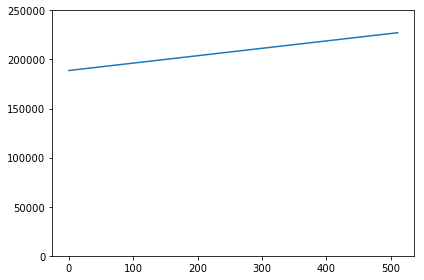

In [35]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return x * a + b

x = np.linspace(0, df.index.shape[0] - 1, df.index.shape[0])
pars, _ = curve_fit(linear, x, df.total_in.values)

plt.plot(x, linear(x, *pars))
plt.ylim(0, 250000)
plt.show()

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


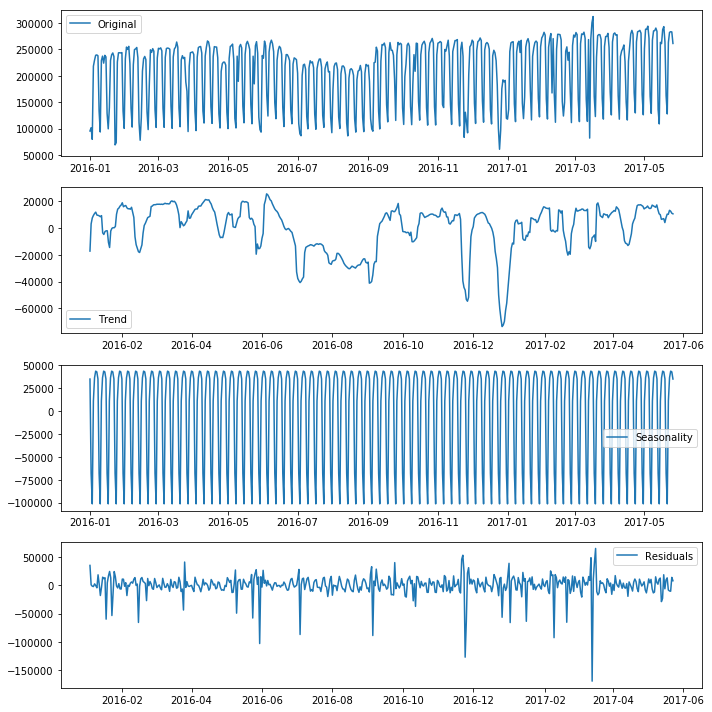

In [36]:
test_stationary = df.total_in - linear(x, *pars)

decomposition = seasonal_decompose(test_stationary)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df['total_in'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
dftest = adfuller(test_stationary, autolag='AIC')
dftest
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
dfoutput

Test Statistic                  -4.259960
p-value                          0.000521
#Lags Used                      15.000000
Number of Observations Used    496.000000
Critical Value (1%)             -3.443603
Critical Value (5%)             -2.867385
Critical Value (10%)            -2.569883
dtype: float64

In [39]:
# df.reset_index(inplace=True)
# df.set_index('date', inplace=True)
df.head()

,l_in,l_out,s72_in,s72_out,s86_in,s86_out,s96_in,s96_out,g68_in,g68_out,...,g103_in,g103_out,g110_in,g110_out,g116_in,g116_out,g125_in,g125_out,total_in,total_out
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,3302.0,3146.0,NaN,NaN,NaN,NaN,NaN,NaN,9521.0,7198.0,...,7678.0,7633.0,5749.0,5347.0,9343.0,5262.0,9084.0,13426.0,95400.0,83212.0
2016-01-02,4254.0,3987.0,NaN,NaN,NaN,NaN,NaN,NaN,4706.0,5430.0,...,6481.0,6787.0,5359.0,4253.0,7507.0,2970.0,10346.0,17843.0,101472.0,96658.0
2016-01-03,4173.0,3275.0,NaN,NaN,NaN,NaN,NaN,NaN,3401.0,4513.0,...,5143.0,6098.0,4219.0,3907.0,6427.0,2747.0,9516.0,17188.0,79575.0,82501.0
2016-01-04,8824.0,7496.0,NaN,NaN,NaN,NaN,NaN,NaN,28379.0,19186.0,...,14419.0,13755.0,12151.0,9270.0,15698.0,8035.0,19381.0,23519.0,218194.0,170870.0
2016-01-05,9622.0,7700.0,NaN,NaN,NaN,NaN,NaN,NaN,31805.0,19920.0,...,15140.0,14409.0,12226.0,9137.0,15590.0,8412.0,19085.0,23511.0,229690.0,175053.0


In [42]:
test_weekly = df.resample('7D').sum()
test_weekly.head()

,l_in,l_out,s72_in,s72_out,s86_in,s86_out,s96_in,s96_out,g68_in,g68_out,...,g103_in,g103_out,g110_in,g110_out,g116_in,g116_out,g125_in,g125_out,total_in,total_out
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,49517.0,39959.0,NaN,NaN,NaN,NaN,NaN,NaN,141621.0,96723.0,...,80779.0,79936.0,65934.0,51654.0,88868.0,45460.0,108834.0,144579.0,1202877.0,970043.0
2016-01-08,59779.0,46946.0,NaN,NaN,NaN,NaN,NaN,NaN,183704.0,118523.0,...,78404.0,71413.0,77425.0,59278.0,102089.0,55036.0,122466.0,155593.0,1393454.0,1071313.0
2016-01-15,55569.0,47444.0,NaN,NaN,NaN,NaN,NaN,NaN,169730.0,108190.0,...,86494.0,84297.0,72702.0,55130.0,96844.0,52785.0,113287.0,141201.0,1316235.0,1019848.0
2016-01-22,53021.0,40207.0,NaN,NaN,NaN,NaN,NaN,NaN,180771.0,116471.0,...,77216.0,60129.0,80299.0,65043.0,95520.0,51702.0,111516.0,139637.0,1335856.0,1007367.0
2016-01-29,64152.0,42517.0,NaN,NaN,NaN,NaN,NaN,NaN,218338.0,146535.0,...,71578.0,36258.0,93068.0,75342.0,107438.0,56452.0,126716.0,157954.0,1470204.0,1092241.0


In [43]:
test_weekly.head()

,l_in,l_out,s72_in,s72_out,s86_in,s86_out,s96_in,s96_out,g68_in,g68_out,...,g103_in,g103_out,g110_in,g110_out,g116_in,g116_out,g125_in,g125_out,total_in,total_out
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,49517.0,39959.0,NaN,NaN,NaN,NaN,NaN,NaN,141621.0,96723.0,...,80779.0,79936.0,65934.0,51654.0,88868.0,45460.0,108834.0,144579.0,1202877.0,970043.0
2016-01-08,59779.0,46946.0,NaN,NaN,NaN,NaN,NaN,NaN,183704.0,118523.0,...,78404.0,71413.0,77425.0,59278.0,102089.0,55036.0,122466.0,155593.0,1393454.0,1071313.0
2016-01-15,55569.0,47444.0,NaN,NaN,NaN,NaN,NaN,NaN,169730.0,108190.0,...,86494.0,84297.0,72702.0,55130.0,96844.0,52785.0,113287.0,141201.0,1316235.0,1019848.0
2016-01-22,53021.0,40207.0,NaN,NaN,NaN,NaN,NaN,NaN,180771.0,116471.0,...,77216.0,60129.0,80299.0,65043.0,95520.0,51702.0,111516.0,139637.0,1335856.0,1007367.0
2016-01-29,64152.0,42517.0,NaN,NaN,NaN,NaN,NaN,NaN,218338.0,146535.0,...,71578.0,36258.0,93068.0,75342.0,107438.0,56452.0,126716.0,157954.0,1470204.0,1092241.0


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


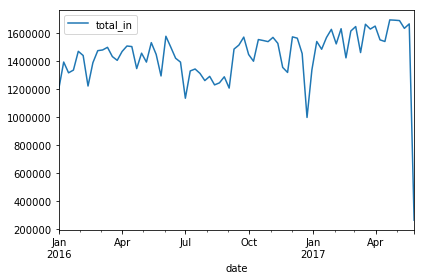

In [44]:
test_weekly.plot(kind='line', y='total_in')

This overall trend looks way better, and our time series is adequately stationary, so we have an idea of our process:
- for times less than the first prediction time, fit a line to get trend
- subtract trend and check for stationary TS
- estimate out to the future...? Try bayesian forecasting

In [56]:
from fbprophet import Prophet

df_small = np.log(df.total_in)
df_small = df_small.reset_index()
df_small.columns = ['ds', 'y']
df_small.head()

,ds,y
0,2016-01-01,11.465834
1,2016-01-02,11.527538
2,2016-01-03,11.284455
3,2016-01-04,12.293140
4,2016-01-05,12.344486


NYC Population will not grow forever... Manhattan in 2010 was about 1.6M, and it is projected to be 1.7M by 2030, around the time that Phase 2 of the 2nd Avenue subway will be done. We can't assume that our growth would continue without bounds, so we will cap it.

In [88]:
m = Prophet(yearly_seasonality=True, growth='logistic', interval_width=0)
cap = np.log(1.7e6)
print(cap)
df_fit = df_small
df_fit['cap'] = cap
m.fit(df_small)

14.346138809


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


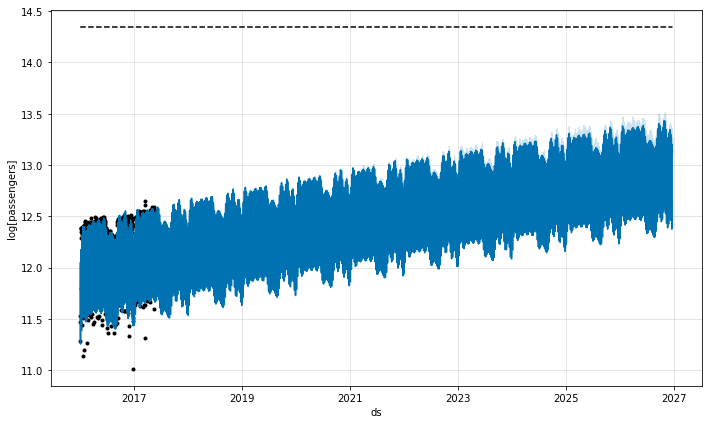

In [89]:
future = m.make_future_dataframe(periods=3500)
future['cap'] = cap
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

_ = m.plot(forecast)
plt.ylabel('log[passengers]')

In [92]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.exp(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
forecast.tail()

,ds,cap,t,cap_scaled,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
4007,2026-12-21,14.346139,7.841487,1.133914,13.091220,-0.028278,-0.028278,13.165526,13.165526,520155.442464,520155.442464,0.082564,0.082564,0.082564,-0.110842,-0.110842,-0.110842,-0.028278,471154.749499
4008,2026-12-22,14.346139,7.843444,1.133914,13.091409,0.084833,0.084833,13.165702,13.165702,563871.245913,563871.245913,0.208912,0.208912,0.208912,-0.124079,-0.124079,-0.124079,0.084833,527678.046871
4009,2026-12-23,14.346139,7.845401,1.133914,13.091597,0.108668,0.108668,13.166261,13.166261,582598.786682,582598.786682,0.244967,0.244967,0.244967,-0.136299,-0.136299,-0.136299,0.108668,540508.439887
4010,2026-12-24,14.346139,7.847358,1.133914,13.091785,0.086838,0.086838,13.166896,13.166896,575670.792117,575670.792117,0.234025,0.234025,0.234025,-0.147187,-0.147187,-0.147187,0.086838,528936.428642
4011,2026-12-25,14.346139,7.849315,1.133914,13.091974,0.039838,0.039838,13.167559,13.167559,541465.313259,541465.313259,0.196293,0.196293,0.196293,-0.156455,-0.156455,-0.156455,0.039838,504746.638726


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


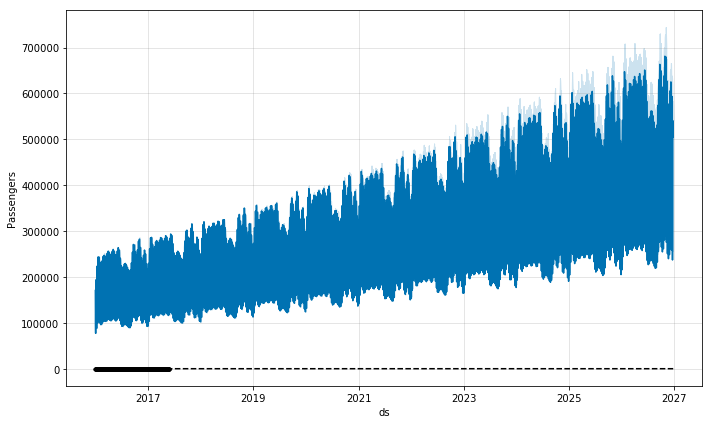

In [93]:
_ = m.plot(forecast)
plt.ylabel('Passengers')

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


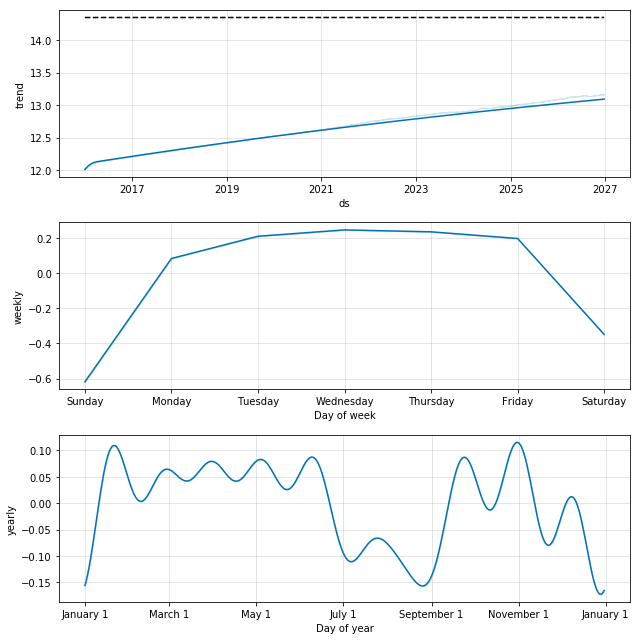

In [90]:
_ = m.plot_components(forecast)